## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# Load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Load in the train data and inspecting the first few rows
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
# Inspecting the data
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [3]:
# Checking for any null-values
train_data[train_data.isnull()].sum()

ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

In [4]:
# Checking distribution of promotion
prom_dist = train_data.groupby('Promotion')['purchase'].value_counts()
prom_dist

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
Name: purchase, dtype: int64

In [5]:
# Calculating and printing group counts 
customer_total = train_data.shape[0]
customer_control = train_data.query('Promotion == "No"').shape[0]
customer_treatment = train_data.query('Promotion == "Yes"').shape[0]
purchase_total = train_data.query('purchase == 1').shape[0]
purchase_control = train_data.query('Promotion == "No" and purchase == 1').shape[0]
purchase_treatment = train_data.query('Promotion == "Yes" and purchase == 1').shape[0]

print('Customer count:', customer_total)
print('Control group count:', customer_control)
print('Treatment group count:', customer_treatment)
print('Total purchase count:', purchase_total)
print('Control purchase count:', purchase_control)
print('Total treatment count:', purchase_treatment)

Customer count: 84534
Control group count: 42170
Treatment group count: 42364
Total purchase count: 1040
Control purchase count: 319
Total treatment count: 721


In [6]:
# Calculating Incremental Response Rate (IRR)
irr = (purchase_treatment / customer_treatment) - (purchase_control / customer_control)
print('IRR:',irr)

IRR: 0.009454547819772702


In [7]:
# Calculating Net Incremental Revenue (NIR)
nir = 10*purchase_treatment - 0.15*customer_treatment - 10*purchase_control 
print('NIR:', nir)

NIR: -2334.5999999999995


### Hypothesis test for IRR value

Null Hypothesis (H0): IRR <= 0;
Alternate Hypothesis (H1): IRR != 0

alpha = 0.05

Bonferroni Correction = alpha / number of measures = 0.025 



In [8]:
# Checking IRR, simulate outcomes under null and compare to observed outcome

n_trials = 200000
p_null  = train_data['purchase'].mean()

sim_control = np.random.binomial(customer_control, p_null, n_trials)
sim_treatment = np.random.binomial(customer_treatment, p_null, n_trials)
samples = (sim_treatment / customer_treatment) - (sim_control / customer_control)

p_val = (samples >= irr).mean()

# Conclusion of the experiment
print('The p-value for the test on IRR is {}. Therefore we reject the null hypothesis that IRR = 0.' .format(p_val))

The p-value for the test on IRR is 0.0. Therefore we reject the null hypothesis that IRR = 0.


### Hypothesis test for NIR value

H0: NIR = 0;
H1: NIR != 0

alpha = 0.05

Bonferroni Correction = alpha / number of measures = 0.025


In [9]:
# Checking NIR, simulate outcomes under null and compare to observed outcome

n_trials = 200000
p_null  = train_data['purchase'].mean()

sim_control = np.random.binomial(customer_control, p_null, n_trials)
sim_treatment = np.random.binomial(customer_treatment, p_null, n_trials)
samples = 10*sim_treatment - 0.15*customer_treatment - 10*sim_control 

p_val = (samples >= nir).mean()

# Conclusion of the experiment
print('The p-value for the test on NIR is {}. Therefore we reject the null hypothesis that NIR = 0.' .format(p_val))


The p-value for the test on NIR is 0.0. Therefore we reject the null hypothesis that NIR = 0.


### Building promotion strategy model

In [10]:
# Creating X and y variables
X = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
y = train_data['purchase'].values

# Scaling X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform train test split in 2:1 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, test_size=0.33, random_state=55)


In [11]:
# Build a pipeline, using n_jobs = -1 to improve processing speeds
pipeline = Pipeline([('clf', RandomForestClassifier(n_jobs=-1, class_weight='balanced'))])

# Checking pipeline parameters
pipeline.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'clf', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__n_estimators', 'clf__n_jobs', 'clf__oob_score', 'clf__random_state', 'clf__verbose', 'clf__warm_start'])

In [12]:
# Hyperparameter tuning, using precision as scoring method
parameters =  {'clf__n_estimators': [50,100,200],
                'clf__max_depth': [3,4,5]}


In [13]:
# Noted it costs the company 0.15 to send out each promotion and it would be best to limit 
# that promotion only to those that are most receptive to the promotion.
# Therefore we want to minimise false positives (ie we are seeking higher Precision, which will be the used metric)
# Also noted that higher the purchase_treatment (true positives), the higher the IRR and NRR.

# passing grid search object
cv = GridSearchCV(pipeline, param_grid = parameters, scoring ='precision')

In [14]:
# Training grid search model
cv.fit(X_train, y_train)

# Predict on test data
y_pred = cv.predict(X_test)

In [15]:
# Evaluating the model
class_report = classification_report(y_test, y_pred)

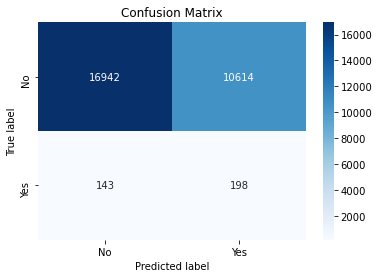

In [16]:
# Confusion matrix

conf_matrix = confusion_matrix(y_test,y_pred)
index = ['No','Yes']
columns = ['No','Yes']

cm_df = pd.DataFrame(conf_matrix, columns, index)                  
sns.heatmap(cm_df,annot=True, cmap='Blues',fmt='g')
plt.plot()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix');

In [17]:
# Printing confusion matrix to check the above chart
confusion_matrix(y_test,y_pred)

array([[16942, 10614],
       [  143,   198]], dtype=int64)

In [18]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    # Scaling dataframe using the above scaler
    df = scaler.transform(df)
    
    # Predict on the data frame
    purchases = cv.predict(df)
    promotion = np.where(purchases == 1, 'Yes','No')
    
    return promotion

In [19]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0198.

Your nir with this strategy is 373.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0197525115048557, 373.1500000000001)